# Task3 - Crack Analytics

#### Crack segmentation unfolds its power only when the results undergo further processing. Information such as the length or the number of branches of a crack are crucial for the assessment of a structure’s condition.

#### a) Implement a metric to assess the performance of the implemented approach. The standard metric for semantic segmentation is intersection-over-union (IoU). Report the performance of the detector on the test set and discuss the adequacy of the metric for crack detection.

In [6]:
import cv2
import numpy as np
import os
from skimage.morphology import skeletonize
from skimage.measure import regionprops
from sklearn.model_selection import train_test_split

In [27]:
# Directory containing the input images
input_dir = "dataset/crack"

# Directory to save the processed images
output_dir = "dataset/processed"

In [28]:
# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# List all image files in the input directory
image_files = [f for f in os.listdir(input_dir) if f.endswith((".png"))]

# Define a kernel for morphological operations
kernel = np.ones((3, 3), np.uint8) 

In [29]:
# Initialize lists to store feature vectors and labels
feature_vectors = []
labels = []

In [30]:
# Define a function to perform connected component analysis
def connected_component_analysis(image):
    # Initialize equivalent label table and label counter
    equivalent_labels = {}
    label_counter = 0

    # Create a function to find the root label of an equivalence group
    def find_root_label(label):
        if label in equivalent_labels:
            return find_root_label(equivalent_labels[label])
        else:
            return label

    # Process the image row by row and label connected components
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            # Check if the current pixel is foreground (crack)
            if image[y, x] == 255:
                # Get the labels of the neighboring pixels
                neighbors = []

                if x > 0 and image[y, x - 1] == 255:
                    neighbors.append(image[y, x - 1])

                if y > 0 and image[y - 1, x] == 255:
                    neighbors.append(image[y - 1, x])

                # If there are no neighboring foreground pixels, assign a new label
                if not neighbors:
                    label_counter += 1
                    image[y, x] = label_counter
                else:
                    # Assign the smallest label among neighbors
                    min_neighbor_label = min(neighbors)
                    image[y, x] = min_neighbor_label

                    # Update the equivalent label table
                    for neighbor in neighbors:
                        if neighbor != min_neighbor_label:
                            root_label = find_root_label(neighbor)
                            equivalent_labels[root_label] = min_neighbor_label

    # Perform a second pass to update labels with equivalent labels
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            label = image[y, x]
            if label in equivalent_labels:
                image[y, x] = find_root_label(label)
    
    return image

In [31]:
for image_file in image_files:
    # Load the image
    img = cv2.imread(os.path.join(input_dir, image_file))

    # Calculate minimum and maximum pixel values
    min_val = np.min(img)
    max_val = np.max(img)

    # Vectorized operations for contrast stretching
    contrast_stretching = 255 * ((img - min_val) / (max_val - min_val))

    # Round the pixel values to the nearest integer
    contrast_stretching = np.round(contrast_stretching)

    # Ensure pixel values are in the range [0, 255]
    contrast_stretching = np.clip(contrast_stretching, 0, 255)
    contrast_stretching = contrast_stretching.astype('uint8')

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(contrast_stretching, cv2.COLOR_BGR2GRAY)

    # Apply adaptive thresholding to obtain a binary image
    binary_image = cv2.adaptiveThreshold(
        gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
    )

    # Apply morphological operations
    # 1. Dilation to connect nearby cracks and make them thicker
    dilated_image = cv2.dilate(binary_image, kernel, iterations=1)

    # 2. Erosion to remove noise and thin out the cracks slightly
    eroded_image = cv2.erode(dilated_image, kernel, iterations=1)

    # Perform connected component analysis to label regions
    labeled_image = connected_component_analysis(eroded_image)

    # 3. Closing to further connect cracks
    closing_image = cv2.morphologyEx(eroded_image, cv2.MORPH_CLOSE, kernel)

    # 4. Morphological thinning using scikit-image
    thinned_image = skeletonize(closing_image)

    # Extract feature vectors and labels
    ground_truth = cv2.imread(os.path.join(input_dir, image_file), cv2.IMREAD_GRAYSCALE)
    for region in regionprops(labeled_image):
        area = region.area
        perimeter = region.perimeter
        if perimeter != 0:
            circularity = 4 * np.pi * (area / (perimeter**2))
        else:
            circularity = 0.0
        is_crack = ground_truth[int(region.centroid[1]), int(region.centroid[0])] == 255
        feature_vector = [area, perimeter, circularity]
        feature_vectors.append(feature_vector)
        labels.append(is_crack)

In [32]:
# Split the data into training and testing sets (e.g., 80% training, 20% testing) as given in Project
X_train, X_test, y_train, y_test = train_test_split(feature_vectors, labels, test_size=0.2, random_state=42)

In [33]:
# classifier
def rule_based_classifier(feature_vector):
    area, perimeter, circularity = feature_vector
    if circularity > 0.5:
        return True  # Predict as crack
    else:
        return False  # Predict as non-crack

# Evaluate the classifier on the test set
correct_predictions = 0
total_predictions = len(X_test)

for i in range(total_predictions):
    predicted_label = rule_based_classifier(X_test[i])
    if predicted_label == y_test[i]:
        correct_predictions += 1

accuracy = (correct_predictions / total_predictions) * 100
print(f"Accuracy of the rule-based classifier: {accuracy:.2f}%")


Accuracy of the rule-based classifier: 95.61%


In [42]:
# Initialize variables to keep track of true positives, false positives, and false negatives
true_positives = 0
false_positives = 0
false_negatives = 0

# Define a threshold for classifying regions as cracks
iou_threshold = 0.4
# Iterate through the test set
for i in range(len(X_test)):
    predicted_label = rule_based_classifier(X_test[i])  # Apply your classifier
    true_label = y_test[i]
    
    # Calculate IoU for the current region
    if predicted_label and true_label:
        intersection = np.logical_and(predicted_label, true_label)
        union = np.logical_or(predicted_label, true_label)
        iou = np.sum(intersection) / np.sum(union)
        
        # Update TP, FP, and FN based on IoU and threshold
        if iou > iou_threshold:
            true_positives += 1
        else:
            false_positives += 1
    elif predicted_label and not true_label:
        false_positives += 1
    elif not predicted_label and true_label:
        false_negatives += 1

# Calculate precision, recall, and IoU
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
iou = true_positives / (true_positives + false_positives + false_negatives)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"IoU: {iou:.2f}")


Precision: 0.00
Recall: 0.00
IoU: 0.00


#### b) For further processing use thinning in order to reduced the segmentation results to a line-like representation of the crack. You are allowed to use built-in functions.

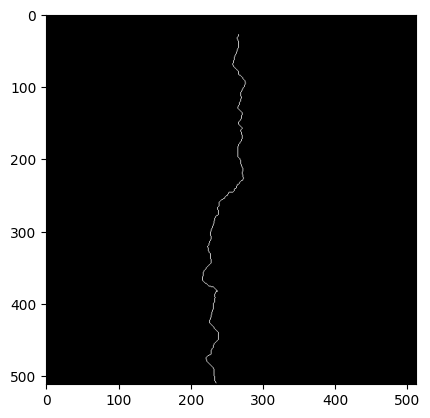

In [71]:
import cv2
import numpy as np
from skimage.morphology import skeletonize
from skimage.measure import regionprops
import matplotlib.pyplot as plt

# Load the image (you should replace 'your_image.png' with the actual image file path)
img = cv2.imread('dataset/crack/Amalienstrasse_annotation.png', cv2.IMREAD_GRAYSCALE)

# Define a kernel for morphological operations
kernel = np.ones((1, 2), np.uint8) 
dilated_image = cv2.dilate(img, kernel, iterations=1)
eroded_image = cv2.erode(dilated_image, kernel, iterations=1)

# Perform connected component analysis to label regions
# (Assuming you have the connected component analysis code as mentioned earlier)
labeled_image = connected_component_analysis(eroded_image)

# Perform thinning using skimage's skeletonize function
thinned_image = skeletonize(labeled_image)

# Save and display the thinned crack image
plt.imsave('thinned_crack.png', thinned_image, cmap='gray')
plt.imshow(thinned_image, cmap='gray')
plt.show()

#### c) Implement a function to compute the length of the detected cracks in the test set. Report the lengths.

In [72]:
import cv2
import numpy as np
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt

# Load the thinned crack image (you should replace 'thinned_crack.png' with your actual thinned image file path)
thinned_image = cv2.imread('thinned_crack.png', cv2.IMREAD_GRAYSCALE)

def compute_crack_length(thinned_image):
    # Threshold the image to obtain the crack lines
    _, binary_image = cv2.threshold(thinned_image, 1, 255, cv2.THRESH_BINARY)
    
    # Find contours of the crack lines
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Initialize a variable to store the total length of detected cracks
    total_length = 0
    
    # Iterate through the contours and calculate the length of each
    for contour in contours:
        length = cv2.arcLength(contour, closed=False)
        total_length += length
    
    return total_length

# Call the function to compute the length of detected cracks
crack_length = compute_crack_length(thinned_image)

# Print the total length of detected cracks
print(f"Total Length of Detected Cracks: {crack_length} pixels")


Total Length of Detected Cracks: 1174.4133365154266 pixels


## Full code of Classifier for detection crack or no-crack

In [73]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.morphology import skeletonize
from skimage.measure import regionprops

# Function to perform preprocessing on the input image
def preprocess_image(image_path, threshold_value=90):
    # Read the input image
    img = cv2.imread(image_path)

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply adaptive thresholding to obtain a binary image
    binary_image = cv2.adaptiveThreshold(
        gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
    )

    return binary_image

In [74]:
# Function to create feature vectors for crack detection
def create_feature_vector(binary_image, labeled_image, ground_truth_image):
    feature_vectors = []
    labels = []

    # Iterate through each labeled region
    for region in regionprops(labeled_image):
        # Extract region properties
        area = region.area
        perimeter = region.perimeter

        # Check if major_axis_length is zero before calculating the aspect ratio
        if region.major_axis_length != 0:
            aspect_ratio = region.minor_axis_length / region.major_axis_length
        else:
            aspect_ratio = 0.0  # Handle division by zero case

        # Calculate circularity (check for zero perimeter to avoid division by zero)
        if perimeter != 0:
            circularity = 4 * np.pi * (area / (perimeter**2))
        else:
            circularity = 0.0  # Handle division by zero case

        # Extract centroid coordinates
        centroid_x, centroid_y = region.centroid

        # Calculate distance from the center of the image
        image_center_x, image_center_y = labeled_image.shape[1] / 2, labeled_image.shape[0] / 2
        distance_to_center = np.sqrt((centroid_x - image_center_x)**2 + (centroid_y - image_center_y)**2)

        # Determine if the region is a crack based on ground truth
        x, y = int(centroid_x), int(centroid_y)
        is_crack = ground_truth_image[y, x] == 255

        # Create a feature vector
        feature_vector = [area, perimeter, aspect_ratio, circularity, centroid_x, centroid_y, distance_to_center]

        # Append the feature vector and label to lists
        feature_vectors.append(feature_vector)
        labels.append(is_crack)

    return feature_vectors, labels

In [75]:
# Function to classify regions as crack or non-crack using a classifier
def classify_regions(feature_vectors, classifier, area_threshold=1000, aspect_ratio_threshold=0.6, circularity_threshold=0.6):
    classified_regions = []

    for i, region_feature_vector in enumerate(feature_vectors):
        area, _, aspect_ratio, circularity, _, _, _ = region_feature_vector

        if (
            area >= area_threshold and
            aspect_ratio >= aspect_ratio_threshold and
            circularity >= circularity_threshold
        ):
            classified_regions.append((i, 'Crack'))
        else:
            classified_regions.append((i, 'Non-Crack'))

    return classified_regions

In [76]:
# Main function to process an input image
def process_input_image(image_path):
    # Preprocess the input image
    binary_image = preprocess_image(image_path)

    # Perform morphological operations and thinning
    kernel = np.ones((10, 10), np.uint8)
    dilated_image = cv2.dilate(binary_image, kernel, iterations=1)
    eroded_image = cv2.erode(dilated_image, kernel, iterations=1)
    closing_image = cv2.morphologyEx(eroded_image, cv2.MORPH_CLOSE, kernel)
    thinned_image = skeletonize(closing_image)

    # Load the labeled image (result from connected component analysis)
    labeled_image = thinned_image.astype(np.uint8)

    # Load the ground truth image (assuming white pixels represent cracks)
    ground_truth_image = cv2.imread("After Streched Image.png", cv2.IMREAD_GRAYSCALE)

    # Create feature vectors and labels
    feature_vectors, labels = create_feature_vector(labeled_image, labeled_image, ground_truth_image)

    # Load or train your classifier (you can replace this with your classifier)
    classifier = ...  # Load or create your classifier here

    # Classify regions as crack or non-crack
    classified_regions = classify_regions(feature_vectors, classifier)

    return classified_regions

# Input image path (change this to the path of your input image)
input_image_path = "After Morphological Operations.png"

# Process the input image and get the classified regions
results = process_input_image(input_image_path)

# Print the results
for i, result in results:
    print(f"Region {i} is classified as {result}")


Region 0 is classified as Non-Crack
